In [ ]:
!pip install transformers
!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 483.9/483.9 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.4/159.4 kB 14.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 10.6 MB

In [ ]:
import numpy as np
import pandas as pd
import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
device = torch.device('cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/FakeNewsDetectionDataset

/content/drive/MyDrive/FakeNewsDetectionDataset


In [ ]:
true_data = pd.read_csv('True.csv')
fake_data = pd.read_csv('Fake.csv')

true_data['Target'] = ['True']*len(true_data)
fake_data['Target'] = ['Fake']*len(fake_data)

data = true_data.append(fake_data).sample(frac=1).reset_index().drop(columns=['index'])

print(data.shape)
data.head(3)

(44898, 5)


,title,text,subject,date,Target
0,Trump ROYALLY Blindsided His Own National Sec...,One of the major things with Donald Trump s sp...,News,"June 6, 2017",Fake
1,EU agreed no sum needed to move talks forward:...,LONDON (Reuters) - The European Union agreed t...,worldnews,"November 12, 2017",True
2,"Powell reveals disgust with Trump, distaste fo...",WASHINGTON (Reuters) - Former Secretary of Sta...,politicsNews,"September 14, 2016",True


In [ ]:
data['label'] = pd.get_dummies(data.Target)['Fake']

In [ ]:
data.head()

,title,text,subject,date,Target,label
0,Trump ROYALLY Blindsided His Own National Sec...,One of the major things with Donald Trump s sp...,News,"June 6, 2017",Fake,1
1,EU agreed no sum needed to move talks forward:...,LONDON (Reuters) - The European Union agreed t...,worldnews,"November 12, 2017",True,0
2,"Powell reveals disgust with Trump, distaste fo...",WASHINGTON (Reuters) - Former Secretary of Sta...,politicsNews,"September 14, 2016",True,0
3,ULTIMATE DISRESPECT: VA Sent Mail Related To D...,Our current government can t be bothered with ...,Government News,"Aug 20, 2015",Fake,1
4,PERFECT! President Trump Is Laughing Hysterica...,"Last week, after President Trump retweeted a h...",politics,"Jul 10, 2017",Fake,1


In [ ]:
train_data, temp_data, train_label, temp_label = train_test_split(data['title'], data['label'],
                                                                  random_state=2018,test_size=0.3,
                                                                  stratify=data['Target'])
val_data, test_data, val_label, test_label = train_test_split(temp_data, temp_label,
                                                                  random_state=2018,test_size=0.5,
                                                                  stratify=temp_label)

In [ ]:

bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Text(0.5, 0, 'Number of texts')

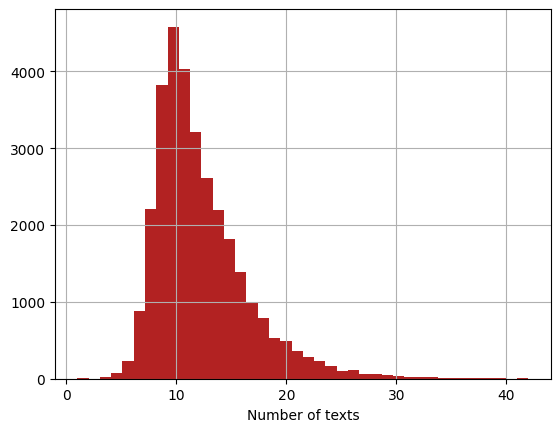

In [ ]:
seq_len = [len(title.split()) for title in train_data]
pd.Series(seq_len).hist(bins = 40, color='firebrick')
plt.xlabel('Number of words')
plt.xlabel('Number of texts')

In [ ]:
MAX_LENGTH = 15
tokens_train = tokenizer.batch_encode_plus(train_data.tolist(), max_length=MAX_LENGTH,
                                           pad_to_max_length=True, truncation=True)
tokens_test = tokenizer.batch_encode_plus(test_data.tolist(), max_length=MAX_LENGTH,
                                           pad_to_max_length=True, truncation=True)
tokens_val = tokenizer.batch_encode_plus(val_data.tolist(), max_length=MAX_LENGTH,
                                           pad_to_max_length=True, truncation=True)



In [ ]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_label.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_label.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_label.tolist())

In [ ]:
assert train_seq.size(0) == train_mask.size(0) == train_y.size(0), "Size mismatch between tensors"


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32
train_dataset = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

val_dataset = TensorDataset(val_seq, val_mask, val_y)
val_sampler = RandomSampler(val_dataset)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=batch_size)



In [ ]:
for param in bert.parameters():
  param.requires_grad = False

In [ ]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
      super(BERT_Arch, self).__init__()
      self.bert = bert
      self.dropout = nn.Dropout(0.1)            # dropout layer
      self.relu =  nn.ReLU()                    # relu activation function
      self.fc1 = nn.Linear(768,512)             # dense layer 1
      self.fc2 = nn.Linear(512,2)               # dense layer 2 (Output layer)
      self.softmax = nn.LogSoftmax(dim=1)       # softmax activation function
    def forward(self, sent_id, mask):           # define the forward pass
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
                                                # pass the inputs to the model
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)                           # output layer
      x = self.softmax(x)                       # apply softmax activation
      return x

model = BERT_Arch(bert)
# Defining the hyperparameters (optimizer, weights of the classes and the epochs)
# Define the optimizer
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate
# Define the loss function
cross_entropy  = nn.NLLLoss()
# Number of training epochs
epochs = 2

In [ ]:
# import torch.nn.functional as F

# class AlternativeBERT_Arch(nn.Module):
#     def __init__(self, bert):
#         super(AlternativeBERT_Arch, self).__init__()
#         self.bert = bert
#         self.dropout = nn.Dropout(0.1)
#         self.fc1 = nn.Linear(768, 256)  # Reduce the number of hidden units in the first dense layer
#         self.fc2 = nn.Linear(256, 2)    # Output layer for binary classification

#     def forward(self, sent_id, mask):
#         cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
#         x = self.fc1(cls_hs)
#         x = F.relu(x)                 # Use PyTorch's functional ReLU
#         x = self.dropout(x)
#         x = self.fc2(x)
#         return x
# model = AlternativeBERT_Arch(bert)
# # Defining the hyperparameters (optimizer, weights of the classes and the epochs)
# # Define the optimizer
# from transformers import AdamW
# optimizer = AdamW(model.parameters(),
#                   lr = 1e-5)          # learning rate
# # Define the loss function
# cross_entropy  = nn.NLLLoss()
# # Number of training epochs
# epochs = 2

In [ ]:
# Defining training and evaluation functions
def train():
  model.train()
  total_loss, total_accuracy = 0, 0

  for step,batch in enumerate(train_dataloader):                # iterate over batches
    if step % 50 == 0 and not step == 0:                        # progress update after every 50 batches.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]                                  # push the batch to gpu
    sent_id, mask, labels = batch
    model.zero_grad()                                           # clear previously calculated gradients
    preds = model(sent_id, mask)                                # get model predictions for current batch
    loss = cross_entropy(preds, labels)                         # compute loss between actual & predicted values
    total_loss = total_loss + loss.item()                       # add on to the total loss
    loss.backward()                                             # backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # clip gradients to 1.0. It helps in preventing exploding gradient problem
    optimizer.step()                                            # update parameters
    preds=preds.detach().cpu().numpy()                          # model predictions are stored on GPU. So, push it to CPU

  avg_loss = total_loss / len(train_dataloader)                 # compute training loss of the epoch
                                                                # reshape predictions in form of (# samples, # classes)
  return avg_loss                                 # returns the loss and predictions

def evaluate():
  print("\nEvaluating...")
  model.eval()                                    # Deactivate dropout layers
  total_loss, total_accuracy = 0, 0
  for step,batch in enumerate(val_dataloader):    # Iterate over batches
    if step % 50 == 0 and not step == 0:          # Progress update every 50 batches.
                                                  # Calculate elapsed time in minutes.
                                                  # Elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
                                                  # Report progress
    batch = [t for t in batch]                    # Push the batch to GPU
    sent_id, mask, labels = batch
    with torch.no_grad():                         # Deactivate autograd
      preds = model(sent_id, mask)                # Model predictions
      loss = cross_entropy(preds,labels)          # Compute the validation loss between actual and predicted values
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)         # compute the validation loss of the epoch
  return avg_loss

In [ ]:
# Train and predict
best_valid_loss = float('inf')
train_losses=[]                   # empty lists to store training and validation loss of each epoch
valid_losses=[]

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss = train()                       # train model
    valid_loss = evaluate()                    # evaluate model
    if valid_loss < best_valid_loss:              # save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'c2_new_model_weights.pt')
    train_losses.append(train_loss)               # append training and validation loss
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 2
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Batch   600  of    983.
  Batch   650  of    983.
  Batch   700  of    983.
  Batch   750  of    983.
  Batch   800  of    983.
  Batch   850  of    983.
  Batch   900  of    983.
  Batch   950  of    983.

Evaluating...
  Batch    50  of    211.
  Batch   100  of    211.
  Batch   150  of    211.
  Batch   200  of    211.

Training Loss: 0.563
Validation Loss: 0.494

 Epoch 2 / 2
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Batch   600  of    983.
  

In [ ]:
# load weights of best model
path = '/content/drive/MyDrive/FakeNewsDetectionDataset/c2_new_model_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
with torch.no_grad():
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.77      0.92      0.84      3212
           1       0.91      0.75      0.82      3523

    accuracy                           0.83      6735
   macro avg       0.84      0.83      0.83      6735
weighted avg       0.84      0.83      0.83      6735



In [ ]:
# # load weights of best model
# path = 'c1_fakenews_weights.pt'
# model.load_state_dict(torch.load(path))

In [ ]:
# testing on unseen data
unseen_news_text = ["Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing",     # Fake
                    "WATCH: George W. Bush Calls Out Trump For Supporting White Supremacy",               # Fake
                    "U.S. lawmakers question businessman at 2016 Trump Tower meeting: sources",           # True
                    "Trump administration issues new rules on U.S. visa waivers"                          # True
                    ]

# tokenize and encode sequences in the test set
MAX_LENGHT = 15
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_news_text,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

with torch.no_grad():
  preds = model(unseen_seq, unseen_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
preds

array([1, 0, 0, 0])